# Hybrid SLR

    Following Ruben's Suggestion: --- it didn't pan out...
    

    In the 'hybrid' models I was trying to capture the dependency the y-intercept has and include them in the calculations. While this has the benefit of somehow increasing the precision of our predictions, the accuracy is decreased substantially. I noted that our predictions seemed to be offset by some constant factor, and when I calculated this constant factor by regressing a line on the predicted vs. actual measurements I got the same results as my original models. This tells me that the factor already makes up part of the orin

# Imports

In [2]:
import numpy as np
import pandas as pd
import os
import scipy


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

from os.path import join as pjoin

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Data

In [3]:
path = '../data_o/calibration/community_calibration/parsed_data/'
fname = 'community_calibration_dataframe.csv'

mdf = pd.read_csv(pjoin(path,fname), sep=',', index_col='well')

######################################
# correct values used for regression #
######################################
for col in [i for i in mdf.columns[4:].values if 'sdv' not in i]:
    #subtract 'blank' well values
    mdf.loc[:,col] = mdf.loc[:,col] - mdf.loc['H12',col]

In [4]:
mdf.head(2)
mdf.tail(2)

,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,660,670,680,690,700,710,720,730,740,750
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.4,0.50,1.0938,0.0618,1.4928,0.0686,0.8732,0.0660,...,1.2798,1.4125,1.4652,1.2293,0.9723,0.8896,0.8541,0.8298,0.8166,0.8032
A2,A,2,0.4,0.46,1.0292,0.0746,1.3929,0.0742,0.8300,0.0714,...,1.2044,1.3205,1.3658,1.1698,0.9243,0.8486,0.8149,0.7924,0.7793,0.7660


,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,660,670,680,690,700,710,720,730,740,750
well,,,,,,,,,,,,,,,,,,,,,
H11,H,11,0.0,0.09,0.1401,0.1147,0.2207,0.1127,0.127,0.1065,...,0.1686,0.1951,0.2096,0.1752,0.1299,0.1145,0.1073,0.1024,0.0995,0.0972
H12,H,12,0.0,0.00,0.0000,0.1275,0.0000,0.1165,0.000,0.1145,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [5]:
# Use the functions from SynCom SLR Models
# Create function which for every regression at hand is called to retriev b(C) || b(B)   @ either wavelength

# Helper Function

In [6]:

def plot_pred_vs_known(mdf, column='440', ml_model=False):
    
    """This function takes in the previously calculated prediction values and
    outputs the the predicted vs known values for [chlamy] and [bacter], 
    column refers to the variable wavelength used to construct the regression
    that gave rise to the predicted values"""
    
    df = mdf.copy()

    df = set_B_and_C(df, column)
    
    fs = (8, 10)
    
    # bacter figure
    fig0 = plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig0.add_subplot(gs[r,c]))

    
    # get predicted values from column named
    if ml_model:
        Bp = 'B_pML_'+column
    else:
        Bp = 'B_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Bp].max(), df['B'].max())
    smx = smx+.1*smx
    
    sns.scatterplot(x='B', y=Bp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8), ax=axes[0])
    
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [B]')
    axes[0].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[0].set_xlabel('$[B]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.01, right=smx) 
    axes[0].set_ylim(bottom=-0.01, top=smx)



    sns.scatterplot(x='B', y=Bp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12), ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                   loc=2, prop={'size':9})
    axes[1].set_title('Predicted vs. Actual [B]')
    axes[1].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[1].set_xlabel('$[B]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.01, right=smx)
    axes[1].set_ylim(bottom=-0.01, top=smx)

    if ml_model:
        fig0.suptitle("[Bacteria] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig0.suptitle("[Bacteria] Predictions Using Simple Linear Regression Models @"+column, y=.95)
        
    fig0.subplots_adjust(hspace=.3)
    
    #plt.show()
    #plt.close()



    # CHLAMY
    fig1=plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig1.add_subplot(gs[r,c]))

    # get predicted values from column named
    if ml_model:
        Cp = 'C_pML_'+column
    else:
        Cp = 'C_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Cp].max(), df['C'].max())
    smx = smx+.1*smx
    
    
    
    sns.scatterplot(x='C', y=Cp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8), ax=axes[0])


    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [C]')
    axes[0].set_ylabel('$\hat{[C]_{pred}}$')
    axes[0].set_xlabel('$[C]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.01, right=smx)
    axes[0].set_ylim(bottom=-0.01, top=smx)


    sns.scatterplot(x='C', y=Cp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12), ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                  prop={'size':9}, loc=2)
    axes[1].set_title('Predicted vs. Actual [C]')
    axes[1].set_ylabel('$\hat{[C]_{pred}}$')
    axes[1].set_xlabel('$[C]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.01, right=smx)
    axes[1].set_ylim(bottom=-0.01, top=smx)
    
    if ml_model:
        fig1.suptitle("[Chlamy] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig1.suptitle("[Chlamy] Predictions Using Simple Linear Regression Models @"+column, y=.95)
    
    fig1.subplots_adjust(hspace=.3)

    plt.show()
    plt.close()
    
    
def set_B_and_C(tdf, column):
    """This helper function sets the concentraiton values B and
    C on the dataframe for regressiong purposes and so that the 
    plotting function can plot the right values on the x-axis"""
    
    df = tdf.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        value = df.loc[(df['row']==row) & (df['col']==12), column][0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column][0]
        df.loc[df['col']==col, 'C'] = value
    
    return df


def get_B_and_C(df, wav):
    
    """This helper function returns the concentraiton values B and
    C so that plotting function can plot the right values"""
    
    df = df.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    col12= []
    for row in rows:
        col12.append(df.loc[(df['row']==row) & (df['col']==12), wav])
        
    rowH = []
    for col in cols:
        rowH.append(df.loc[(df['row']=='H') & (df['col']==col), wav])
    
    # measured values at 12th and H'th row respectively
    bacter, chlamy = np.array(col12), np.array(rowH)
    
    return bacter, chlamy


def get_row_col_values(df, plate_row_or_col='row', df_col_name='A680'):
    """This function returns the values of either a row or column of the 96 well
    as given in the dataframe. These values are later used to perform a linear 
    regression using scipy.optimize function ROW refers to the chlamy related 
    values, and COL to the bacteria related ones"""
    
    rows = df['row'].unique()
    cols = df['col'].unique()
    
    values_list = []
    if plate_row_or_col=='row':
        for row in rows:
            values_list.append(df.loc[df['row']==row, df_col_name].to_list())
    
    else:
        for col in cols:
            values_list.append(df.loc[df['col']==col, df_col_name].to_list())
                               
    
    return values_list


def linear_regression_for_b(regressor, regressand):
    from sklearn.linear_model import LinearRegression
    
    
    # these are your kBb or kCb    
    lregr = LinearRegression()
    kXb = lregr.fit(X=regressor.reshape(-1,1), y=regressand)
    #print('kXb', kXb.coef_)
    return  kXb.coef_[0]
              
              

def transform_coeffs(coef_tuples):
    
    coef_pairs = [i[j]for i in [kB_A6__kBbA6, kC_A6__kCbA6,
                   kB_A7__kBbA7, kC_A7__kCbA7] for j in range(2)]
    
        
def linear_regression_caller(regressor, regressands, other_analyte_cnt):
    """if regressor is bacter_cnt, then other analyte_cnt is chlamy_cnt"""
    from sklearn.linear_model import LinearRegression
    
    
    # these are your Ax_B or Ax_C values
    ks_and_bs = []
    for R in regressands:
        lregr = LinearRegression()
        k_and_b = lregr.fit(X=regressor.reshape(-1,1), y=R)
        ks_and_bs.append([k_and_b.coef_[0], k_and_b.intercept_])
    
    #print('mean', np.array(ks_and_bs).mean(axis=0))
    #kX = np.array(ks_and_bs).mean(axis=0)[0]    # MEAN
    
    # phi = opposion analyte concentrations (phi(B) = [C])
    kX = ks_and_bs[-1][0] # Regression and  phi(B||C) = 0

    yints =  [params[1] for params in ks_and_bs]

    kXb = linear_regression_for_b(other_analyte_cnt, yints)
    
    return kX, kXb
    
def apply_multivariable_BeerLambert(df, coef_pairs, rgr='560', rgd0='A680', rgd1='A720'):
    """The Multivariable Model"""
    
    tdf = df.copy()
    #print(tdf)
    coefs = np.array(coef_pairs).ravel()
    #print(coefs)
    
    #coefs = [0.789666, 1.613971, 1.600023, 0.832702, 0.711189, 0.8119033,  0.788191, .768645]

    kB6, kBb6, kC6, kCb6 = coefs[0:4]
    kB7, kBb7, kC7, kCb7 = coefs[4:]

    #print(kB6, kBb6, kC6, kCb6)
    #print(kB7, kBb7, kC7, kCb7)
    
    A6 = tdf.loc[:,rgd0].values
    A7 = tdf.loc[:,rgd1].values
    
    #kphi = np.array([kCb6, kCb7,kBb7]).mean()
    
    R = kC6
    G = kC7
    
    P = kB6
    T = kB7
    
    #print((kBb7 - kBb6)/(kBb7*kCb6 - kBb6*kCb7))
        
    
    ### KEEP THESE FOR COMPARISON ###############
    #R = (kC6 + kBb6) # these should be the 
    #G = (kC7 + kBb7) # these should be the 

    #P = (kB6 + kCb6)  # good behavior for Cp
    #T = (kB7 + kCb7)  # good behavior for Cp

    tdf['B_p'+rgr] = ((A6*G - A7*R) / (G*P - R*T)) #* 1.10436108
    tdf['C_p'+rgr] = ((A6*T - A7*P) / (R*T - G*P)) #* 1.9874
    ##############################################
    
    return tdf


In [7]:
# Currently I'm just regressor as 560, but if changed then everything in this
# this box should be run so that the values match accordingly
mdf = set_B_and_C(mdf, column='560')

#################################################

# store absorbance values that will be plotted on one figure  [chlamy]
A680_C = get_row_col_values(mdf, 'row', df_col_name='A680')
A720_C = get_row_col_values(mdf, 'row', df_col_name='A720')

# store absorbance values that will be plotted on one figure  [bacteria]
A680_B = get_row_col_values(mdf, 'col', df_col_name='A680')
A720_B = get_row_col_values(mdf, 'col', df_col_name='A720')

chlamy_cnt = mdf['C'].unique()
bacter_cnt = mdf['B'].unique()

kB_A6__kBbA6 = linear_regression_caller(bacter_cnt, A680_B, chlamy_cnt)
kC_A6__kCbA6 = linear_regression_caller(chlamy_cnt, A680_C, bacter_cnt)
kB_A7__kBbA7 = linear_regression_caller(bacter_cnt, A720_B, chlamy_cnt)
kC_A7__kCbA7 = linear_regression_caller(chlamy_cnt, A720_C, bacter_cnt)




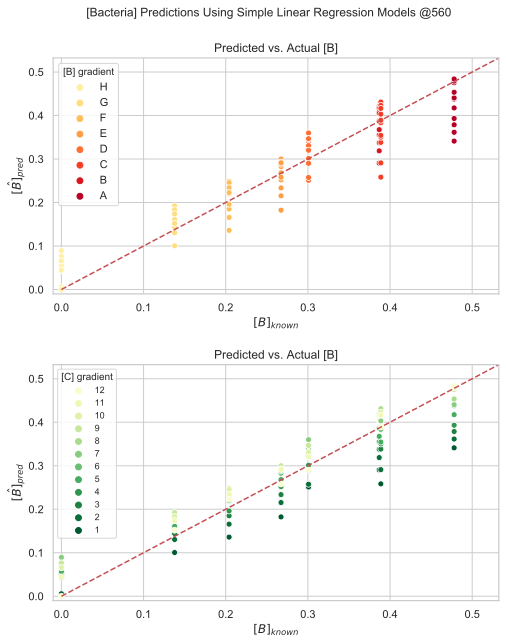

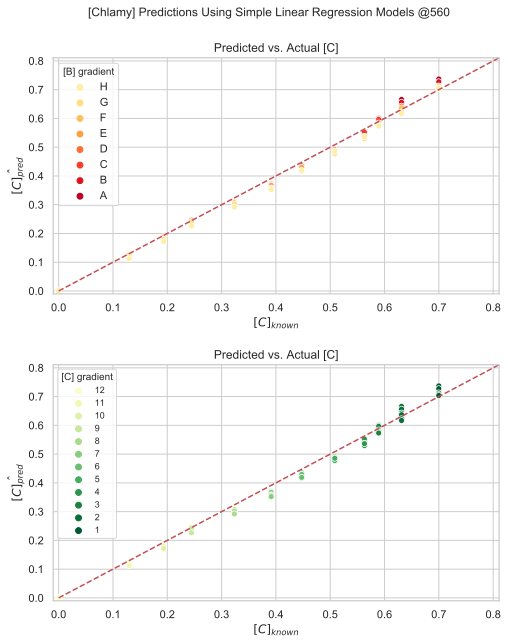

In [8]:
#mdf['A680']

coef_pairs = kB_A6__kBbA6, kC_A6__kCbA6, kB_A7__kBbA7, kC_A7__kCbA7



coefs = np.array(coef_pairs).ravel()

mlt =apply_multivariable_BeerLambert(df=mdf, coef_pairs=coef_pairs, rgr='560',
                                rgd0='A680', rgd1='A720')

plot_pred_vs_known(mlt, column='560', ml_model=False)

In [9]:
mlt['s'] = mlt['B_p560'] + mlt['C_p560']
mlt[['B', 'B_p560', 'C',  'C_p560', '560', 's']]

,B,B_p560,C,C_p560,560,s
well,,,,,,
A1,0.4780,0.341187,0.6999,0.737230,1.0549,1.078417
A2,0.4780,0.361465,0.6313,0.665951,1.0075,1.027416
A3,0.4780,0.378696,0.5892,0.600190,0.9512,0.978886
A4,0.4780,0.393144,0.5630,0.533404,0.9071,0.926548
A5,0.4780,0.417435,0.5084,0.486687,0.8835,0.904122
A6,0.4780,0.437861,0.4475,0.429673,0.8391,0.867534
A7,0.4780,0.440665,0.3913,0.371010,0.7874,0.811675
A8,0.4780,0.453480,0.3235,0.309022,0.7478,0.762502
A9,0.4780,0.475286,0.2445,0.245752,0.6952,0.721039


In [10]:
# fit correction factor

In [11]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

In [12]:
regr = LinearRegression()
X = mlt[['B_p560']]
y = mlt[['B']]

regression1 = regr.fit(X=X, y=y)


In [13]:
regr = LinearRegression()

X = mlt[['C_p560']]
y = mlt[['C']]

regression2 = regr.fit(X=X, y=y)

In [14]:
regression1.coef_
regression2.coef_

array([[1.10436108]])

array([[0.98689757]])